In [1]:
package_paths = [r"C:\Users\benja\Documents\projects\goalscorers"]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
# import pymc as pm
# print(f"Running on PyMC v{pm.__version__}")
# import arviz as az
# print(f"Running on Az v{az.__version__}")
# import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

In [2]:
SCALE_BY_MATCH_EXPECTANCY = False
FINSHING_SKILL = True
SAMPLE_NPXG_DISTRIBUTION = False

In [3]:
season = "2020-2021"
comp_ids = [9, 11, 12, 20]

In [4]:
NUM_CHAINS = 4

# Data

In [5]:
def load_match_expectancies_df(season: str, comp_ids: int) -> pd.DataFrame:
    df_exp = pd.concat(
        [pd.read_csv(c.FilePath.FOOTBALL_DATA_EDITED + f"{season}-league-{comp_id}-historic-odds.csv") for comp_id in comp_ids]
        , ignore_index=True)
    df_exp = (
        df_exp
        .assign(
            datetime=lambda x: pd.to_datetime(x.datetime),
            date=lambda x: x.datetime.dt.date,
            time=lambda x: x.datetime.dt.time,
        )
        .drop(columns=["datetime"])
    )
    return df_exp

In [6]:
def add_expectancies(df: pd.DataFrame, df_exp: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .merge(df_exp, how="left", on=["date", "home_team", "away_team"], validate="m:1")
        .assign(
            team_exp=lambda x: np.where(x.home==0, x.away_exp, x.home_exp),
            opp_team_exp=lambda x: np.where(x.home==0, x.home_exp, x.away_exp),
        )
    )

In [7]:
df_exp = load_match_expectancies_df(season, comp_ids)

In [8]:
df_test_npxg = pd.read_pickle(r"..\npxg\cache\df_test.pickle")
df_test_npg = pd.read_pickle(r"..\npg\cache\df_test.pickle")

In [9]:
merge_on_columns = ["datetime", "home_team", "away_team", "player_id", "player"]

df_test = df_test_npxg.merge(
    df_test_npg[merge_on_columns + [f"F_{c}" for c in range(NUM_CHAINS)] + ["pred_F"]],
    how="left",
    on=merge_on_columns,
    validate="1:1"
)

df_test = add_expectancies(df_test, df_exp)

In [10]:
df = df_test[
    [
        "player_id", "player", "position", "squad", "start", "season", "home", "opposition_team", "frac_90", "home_team", "away_team", "datetime",
        "t", "age", "league", "npxg", "npg", ] + [f"pred_npxg_{c}" for c in range(NUM_CHAINS)] + [f"F_{c}" for c in range(NUM_CHAINS)] + [
            "pred_npxg", "pred_F", "team_exp", "opp_team_exp"
        ]
]

# Eval

In [11]:
def cap_pred_npg(df: pd.DataFrame, max_npg=2.4) -> pd.DataFrame:
    # df.pred_npg_all = df.pred_npg_all.apply(lambda arr: np.where(arr < max_npg, arr, 0.6))
    # df.pred_npg_all = df.pred_npg_all.apply(lambda arr: np.where(arr < 0.07, 0.0, arr))
    return df

In [12]:
def probs(lambda_array: list[float], goals=[0, 1, 2, 3, 4, 5]) -> list[float]:  # length = len(goals)
    if SAMPLE_NPXG_DISTRIBUTION:
        return [scipy.stats.poisson.pmf(goal, mu=lambda_array).mean() for goal in goals]
    else:
        return [scipy.stats.poisson.pmf(goal, mu=lambda_array.mean()) for goal in goals]

In [13]:
def calc_goal_probs(df: pd.DataFrame, pred_col_name="pred_npg_all") -> pd.DataFrame:
    goals = np.sort(df.npg.unique())
    df["probs"] = df[pred_col_name].apply(lambda x: probs(x, goals))

    df_probs = pd.DataFrame(df.probs.tolist(), columns=[f"prob_npg_{goal}" for goal in goals])

    return df_probs

In [14]:
def add_ll_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df["log_likelihood"] = np.log(scipy.stats.poisson.pmf(df.npg, mu=df["pred_npg"]))
    return df

In [15]:
def create_predicted_npg_distribution(df: pd.DataFrame) -> pd.DataFrame:

    for c in range(NUM_CHAINS):
        if not FINSHING_SKILL:
            df[f"F_{c}"] = 0.0
        df[f"pred_npg_{c}"] = df[f"pred_npxg_{c}"] * df[f"F_{c}"].apply(lambda x: np.exp(x))

    df["pred_npg_all"] = df.apply(lambda x: np.concatenate((x.pred_npg_0, x.pred_npg_1)), axis=1)
    for c in range(2, NUM_CHAINS):
        df.pred_npg_all = df.apply(lambda x: np.concatenate((x.pred_npg_all, x[f"pred_npg_{c}"])), axis=1)
    
    return df

In [16]:
def calc_goal_outcomes(df: pd.DataFrame, goals=[0, 1, 2, 3, 4, 5]) -> pd.DataFrame:
    goals = np.sort(df.npg.unique())
    df_npgs = pd.get_dummies(df.npg)
    for goal in goals:
        if goal not in df_npgs.columns:
            df_npgs[goal] = False
    df_npgs = df_npgs[goals]

    return df_npgs

In [17]:
def add_match_expectancy_correction(df: pd.DataFrame) -> pd.DataFrame:
    df_matches = (
        df
        .query("start")
        .groupby(["home_team", "away_team", "datetime", "home"], as_index=False)
        .agg(
            pred_npg_total=("pred_npg90", sum),
            team_exp=("team_exp", "first"),
        )
        .sort_values(["datetime", "home"], ignore_index=True)
        .assign(
            match_exp_npg_total=lambda x: x.team_exp * (1.0 - 0.092),
            correction=lambda x: (x.match_exp_npg_total / x.pred_npg_total)
        )
    )
    return (
        df
        .merge(
            df_matches[["home_team", "away_team", "datetime", "home", "correction"]], 
            how="left", 
            on=["home_team", "away_team", "datetime", "home"],
            validate="m:1"
        )
    )

In [18]:
df_eval = df.copy()
df_eval = create_predicted_npg_distribution(df_eval)
df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
df_eval = cap_pred_npg(df_eval, max_npg=1.4)
if SCALE_BY_MATCH_EXPECTANCY:
    df_eval["pred_npg90"] = df_eval.pred_npg / df_eval.frac_90
    df_eval = add_match_expectancy_correction(df_eval)
    df_eval["pred_npg_all"] = df_eval.pred_npg_all * df_eval.correction
    df_eval = cap_pred_npg(df_eval)
    df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
    
df_probs = calc_goal_probs(df_eval)
df_npgs = calc_goal_outcomes(df_eval)
df_eval = df_eval.join(df_probs)

df_eval["likelihood"] = pd.DataFrame(df_npgs.values * df_probs.values).sum(axis=1)
df_eval["log_likelihood"] = np.log(df_eval.likelihood)
df_eval["mse"] = (df_eval.pred_npg - df_eval.npg) ** 2

### Performance

In [19]:
df_test_set = df_eval.query("start").reset_index(drop=True)

In [20]:
print(f"Number of predictions = {len(df_test_set): ,}")
print("Leagues: ", *df_test_set.league.unique())
print("Dates (inclusive): ", df_test_set.datetime.min(), " to ", df_test_set.datetime.max(), "\n")

print(f"Log likelihood = {df_test_set['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_test_set['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_test_set.log_likelihood.mean()): .3f}")

Number of predictions =  28,078
Leagues:  12 9 11 20
Dates (inclusive):  2020-09-20 16:30:00  to  2021-05-23 19:00:00 

Log likelihood = -8,281.77
MSE =  0.10110
Average likelihood =  0.745


In [21]:
position = "FW"
df_position = df_test_set.query("position == @position").reset_index(drop=True)
print(f"Number of predictions = {len(df_position): ,}")
print(f"Log likelihood = {df_position['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_position['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_position.log_likelihood.mean()): .3f}")

Number of predictions =  4,059
Log likelihood = -2,659.35
MSE =  0.27836
Average likelihood =  0.519


In [22]:
player_id = "87935cf3"
df_player = df_test_set.query("player_id == @player_id").reset_index(drop=True)
print(f"Number of predictions = {len(df_player)}")
print(f"Log likelihood = {df_player['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_player['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_player.log_likelihood.mean()): .3f}")

Number of predictions = 2
Log likelihood = -0.05
MSE =  0.00149
Average likelihood =  0.974


In [23]:
home_team = "Manchester City"
away_team = "Brighton & Hove Albion"
home = 1
df_test_match = df_test_set.query("(home_team == @home_team) & (away_team == @away_team) & (home == @home)").reset_index(drop=True)
print(f"Number of predictions = {len(df_test_match)}")
print(f"Log likelihood = {df_test_match['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_test_match['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_test_match.log_likelihood.mean()): .3f}")

Number of predictions = 10
Log likelihood = -3.02
MSE =  0.07730
Average likelihood =  0.740


In [24]:
df_test_set[["player", "player_id", "t", "position", "home", "home_team", "away_team", "frac_90", "pred_npg", "npg"]]

,player,player_id,t,position,home,home_team,away_team,frac_90,pred_npg,npg
0,Florian Lejeune,6eaed4eb,2,CB,0,Granada,Alavés,1.000,0.024,0
1,Rodrigo Ely,fd47b4f2,2,CB,0,Granada,Alavés,0.500,0.024,0
2,Víctor Laguardia,b7c99b9b,2,CB,0,Granada,Alavés,1.000,0.086,0
3,Pere Pons,29b61deb,2,CM,0,Granada,Alavés,1.000,0.010,0
4,Rodrigo Battaglia,d637fc22,2,CM,0,Granada,Alavés,1.000,0.052,0
...,...,...,...,...,...,...,...,...,...,...
28073,Youssef En-Nesyri,04e17fd5,38,FW,1,Sevilla,Alavés,1.000,0.860,0
28074,Lucas Ocampos,a08b974a,38,W,1,Sevilla,Alavés,0.611,0.262,0
28075,Suso,4e219ad2,38,W,1,Sevilla,Alavés,0.811,0.106,0
28076,Franco Vázquez,467bae22,38,WM,1,Sevilla,Alavés,0.611,0.086,0


In [25]:
df_test_table = df_test_set.copy()#.query("position == 'FW'")

goals = np.sort(df_test_table.npg.unique())

df_npgs_test_table =  calc_goal_outcomes(df_test_table)
df_probs_test_table =  calc_goal_probs(df_test_table)

df_table = (
    pd.DataFrame({"goals": goals, 
                  "obs": df_npgs_test_table.sum().values, 
                  "exp": df_probs_test_table.sum().values})
)

# Cap the chi-squared table s.t. most extreme category has at least 5 obs 
idx = df_table.index.max()
while (df_table.loc[idx, "obs"] < 5):
    df_table.loc[idx - 1, :] += df_table.loc[idx, :]
    df_table = df_table.iloc[: idx]
    idx = df_table.index.max()

df_table = (
    df_table
    .assign(
        goals=lambda x: x.index,
        mean_obs=lambda x: x.obs / x.obs.sum(),
        mean_exp=lambda x: x.exp / x.obs.sum(),
        t_stat=lambda x: (x.obs - x.exp) ** 2 / x.exp
    )
    [["goals", "mean_obs", "mean_exp", "obs", "exp", "t_stat"]]
)
t_stat = df_table.t_stat.sum()
p_val = 1 - scipy.stats.chi2.cdf(t_stat, len(df_table) - 1)
print(f"Chi-Squared test p-value: {p_val: .5f}")
df_table

Chi-Squared test p-value:  0.00000


,goals,mean_obs,mean_exp,obs,exp,t_stat
0,0,0.905,0.909,25414,"25,510.993",0.369
1,1,0.085,0.075,2394,"2,095.597",42.491
2,2,0.009,0.012,244,348.374,31.271
3,3,0.001,0.004,26,108.664,62.885


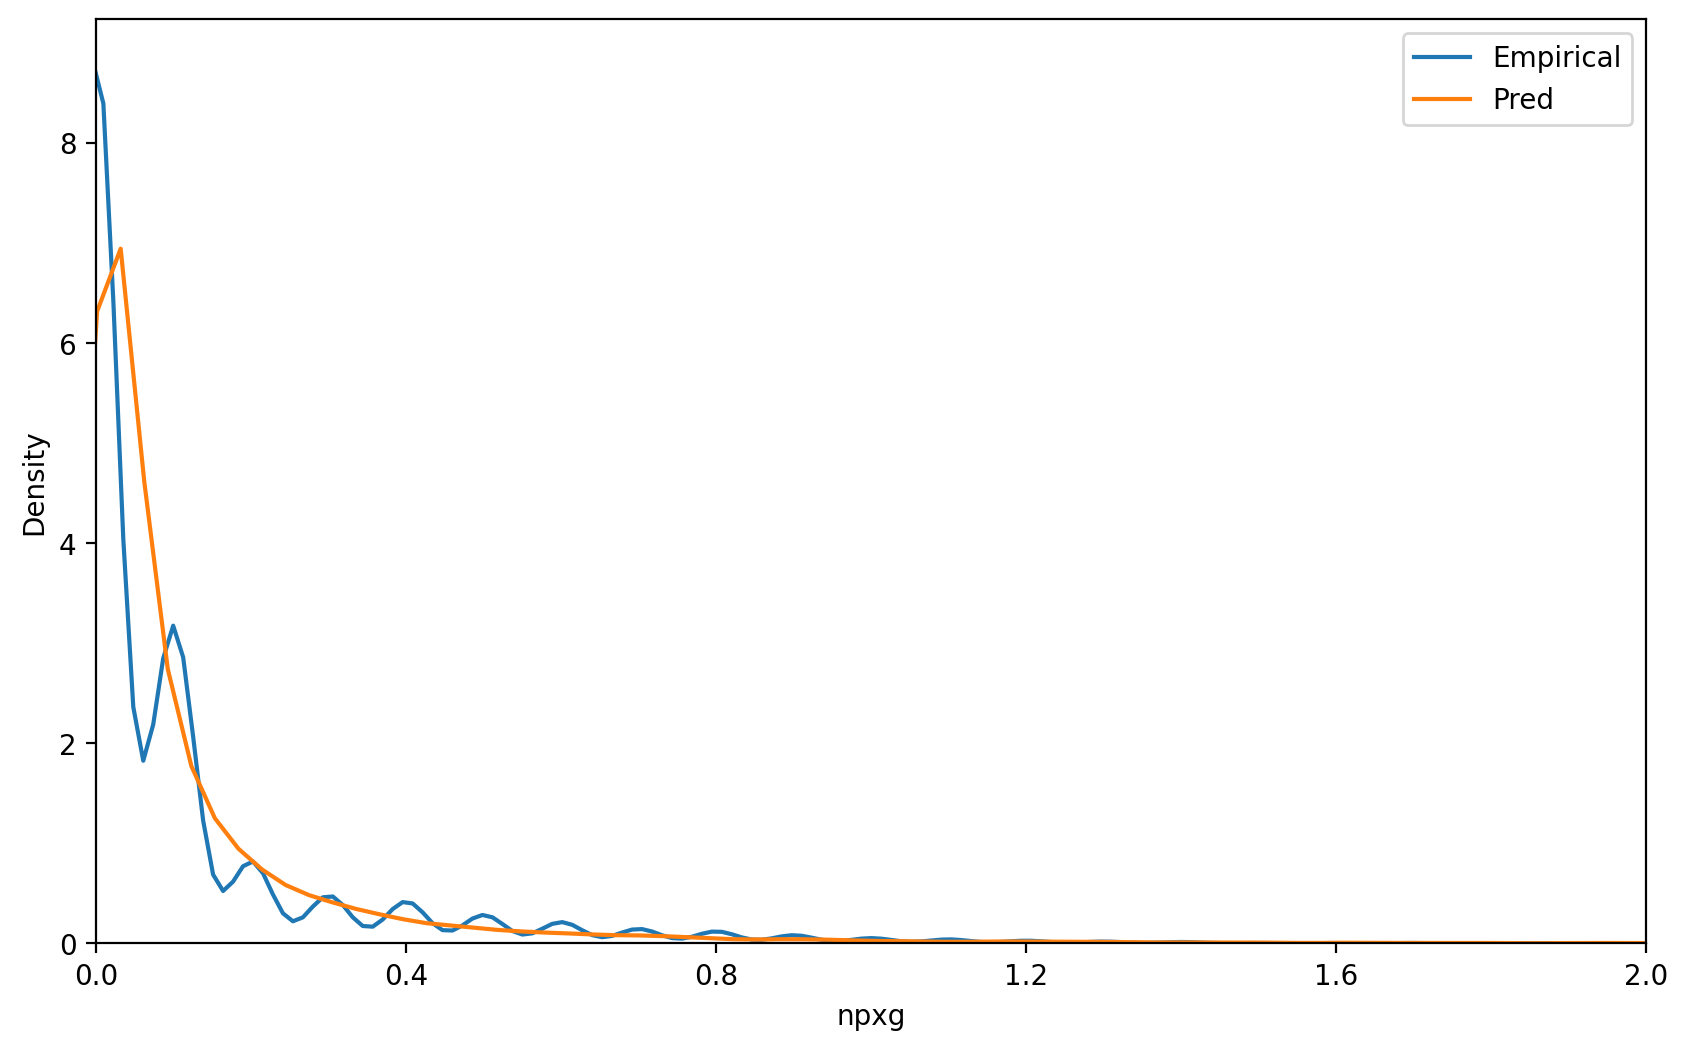

In [26]:
# Expectancies vs observed expectancies

df_test_plot = df_test_set#.query("position == 'WM'")

plt.xticks(np.arange(0, 3.2, 0.4))
plt.xlim(0.0, 2.0)
sns.kdeplot(df_test_plot.npxg)
pred_npg_sample = np.array([])
for player_match in df_test_plot.pred_npg_all.values:
    pred_npg_sample = np.concatenate((pred_npg_sample, np.random.choice(player_match, 1, True)))
sns.kdeplot(pred_npg_sample)
plt.legend(["Empirical", "Pred"])
plt.show()